<font size="6"><center>**Model Building: CV and Pipelines**</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
import pandas as pd


In [4]:
from src.data_api import sources, sinks
from src import utils, tags

from src import mle 

In [5]:
conf = utils.get_conf()

In [6]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_top = float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

val_dt = fparams['split_dt']['valid']
test_dt = fparams['split_dt']['test']

In [7]:
start_dt, val_dt, test_dt, end_dt

('2015-01-01', '2016-12-31', '2017-06-30', '2017-12-31')

In [8]:
K_FOLDS = 3
RND_SEED = 123

# Load Data

In [9]:
feats_and_targets = sources.read_data(
    'feats_and_targets.csv', layer='interim',
    parse_dates=['date'], index_col=['date', 'ticker'])
feats_and_targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 374331 entries, (Timestamp('2015-01-02 00:00:00'), 'A') to (Timestamp('2017-12-29 00:00:00'), 'ZTS')
Columns: 28 entries, sector to split_3f
dtypes: bool(1), float64(24), object(3)
memory usage: 79.0+ MB


In [10]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,sector,SP500,y_fwd_logrets_5d,x_intrad_upshadow,x_intrad_loshadow,x_returns_1d,x_returns_5d,x_zscore_5d,x_zscore_vol_5d,x_macd_5d_vs_20d,x_rsi,x_zscore_20d,x_zscore_vol_20d,x_zscore_60d,x_zscore_vol_60d,x_bb_60d,x_macd_50d_vs_252d,x_returns_1y,x_rets5d_vol_60d,x_rets5d_vol_120d,x_mkt_dispersion,x_wday_cos,x_wday_sin,x_is_eoq,x_mkt_volat_60d,x_mkt_volat_120d,split,split_3f
date,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,A,Capital Goods,-0.0147,0.0007,0.1264,0.1847,-0.0069,-0.0115,-1.4744,0.9398,0.2672,55.3864,-0.1928,-0.5010,0.1058,-0.8054,0.0000,0.4378,0.1129,0.0405,0.0336,0.0543,0.3090,-0.9511,False,0.0236,0.0192,1.dev,1.train
2015-01-05,A,Capital Goods,-0.0341,0.0078,0.1361,0.0972,-0.0189,-0.0365,-1.5635,1.5077,0.0948,55.6667,-0.8393,-0.0693,-0.3988,-0.4243,0.0000,0.4540,0.1001,0.0406,0.0338,0.0628,1.0000,0.0000,False,0.0241,0.0194,1.dev,1.train
2017-12-28,ZTS,Health Care,0.0011,0.0133,0.1100,0.2500,-0.0008,-0.0044,0.5586,-1.2001,0.2580,59.9842,0.6349,-1.4923,1.0820,-1.6623,0.0000,8.6920,0.3552,0.0237,0.0218,0.0547,-0.8090,-0.5878,False,0.0057,0.0068,2.test,3.test
2017-12-29,ZTS,Health Care,-0.0036,0.0301,0.2100,0.0000,-0.0048,-0.0033,-0.9547,1.3702,0.2225,65.2919,0.0366,-0.0578,0.9494,-0.5330,0.0000,8.7416,0.3557,0.0238,0.0218,0.0637,0.3090,-0.9511,False,0.0056,0.0068,2.test,3.test


In [11]:
feats_and_targets.columns

Index(['sector', 'SP500', 'y_fwd_logrets_5d', 'x_intrad_upshadow',
       'x_intrad_loshadow', 'x_returns_1d', 'x_returns_5d', 'x_zscore_5d',
       'x_zscore_vol_5d', 'x_macd_5d_vs_20d', 'x_rsi', 'x_zscore_20d',
       'x_zscore_vol_20d', 'x_zscore_60d', 'x_zscore_vol_60d', 'x_bb_60d',
       'x_macd_50d_vs_252d', 'x_returns_1y', 'x_rets5d_vol_60d',
       'x_rets5d_vol_120d', 'x_mkt_dispersion', 'x_wday_cos', 'x_wday_sin',
       'x_is_eoq', 'x_mkt_volat_60d', 'x_mkt_volat_120d', 'split', 'split_3f'],
      dtype='object')

# Data Preparation

In [12]:
features = feats_and_targets.filter(regex='x_|sector').columns
label = 'y_fwd_logrets_5d'

In [13]:
features

Index(['sector', 'x_intrad_upshadow', 'x_intrad_loshadow', 'x_returns_1d',
       'x_returns_5d', 'x_zscore_5d', 'x_zscore_vol_5d', 'x_macd_5d_vs_20d',
       'x_rsi', 'x_zscore_20d', 'x_zscore_vol_20d', 'x_zscore_60d',
       'x_zscore_vol_60d', 'x_bb_60d', 'x_macd_50d_vs_252d', 'x_returns_1y',
       'x_rets5d_vol_60d', 'x_rets5d_vol_120d', 'x_mkt_dispersion',
       'x_wday_cos', 'x_wday_sin', 'x_is_eoq', 'x_mkt_volat_60d',
       'x_mkt_volat_120d'],
      dtype='object')

In [14]:
feats_and_targets = feats_and_targets.replace({np.inf: np.nan, -np.inf: np.nan})

# Splitting

In [15]:
df_dev = feats_and_targets.query('split == "1.dev"')
X_dev = df_dev[features]
y_dev = df_dev[label]

df_test = feats_and_targets.query('split == "2.test"')
X_test =  df_test[features]
y_test =  df_test[label]

## Cross Validation

In [16]:
cvts_2f = mle.GroupTimeSeriesSplit(n_splits=K_FOLDS)

groups_idx_2f = [x.year*10000 + x.month*100 + x.day for x in X_dev.index.get_level_values('date')]

# Model Building

## Pipeline 

This pipeine can be easly achieved with pandas, it is just an example

sklearn pipelines reference: https://github.com/justmarkham/scikit-learn-tips

In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

enc.categories_

enc.transform([['Female', 1], ['Male', 4]]).toarray()


array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan,
                         strategy='median')
imp.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp.transform(X))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


In [19]:
from sklearn.compose import ColumnTransformer


In [20]:
cols_imp = ['x_intrad_upshadow', 'x_intrad_loshadow', 'x_returns_5d', 'x_zscore_5d',
       'x_zscore_vol_5d', 'x_macd_5d_vs_20d', 'x_rsi', 'x_zscore_20d',
       'x_zscore_vol_20d', 'x_zscore_60d', 'x_zscore_vol_60d', 'x_bb_60d',
       'x_macd_50d_vs_252d', 'x_returns_1y', 'x_rets5d_vol_60d',
       'x_rets5d_vol_120d', 'x_mkt_dispersion',
        'x_mkt_volat_60d', 'x_mkt_volat_120d']

In [21]:
cols_ohe = ['x_is_eoq', 'sector']

In [22]:
fte_ct = ColumnTransformer([
        ('imp', imp, cols_imp),
        ('ohe', enc, cols_ohe)
    ],
    remainder='drop')

In [23]:
ex_fte = fte_ct.fit_transform(X_dev)
ex_fte[0:2,:]

array([[ 1.26397303e-01,  1.84734520e-01, -1.14929740e-02,
        -1.47438391e+00,  9.39756913e-01,  2.67206261e-01,
         5.53863691e+01, -1.92813350e-01, -5.01026498e-01,
         1.05834549e-01, -8.05410411e-01,  0.00000000e+00,
         4.37773000e-01,  1.12945036e-01,  4.04808336e-02,
         3.36449760e-02,  5.43257830e-02,  2.36196625e-02,
         1.91543200e-02,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.36120173e-01,  9.72286947e-02, -3.64683111e-02,
        -1.56346147e+00,  1.50769854e+00,  9.47771734e-02,
         5.56667213e+01, -8.39302226e-01, -6.92819324e-02,
        -3.98823870e-01, -4.24335427e-01,  0.00000000e+00,
         4.53981162e-01,  1.00068799e-01,  4.05903281e-02,
         3.38238280e-02,  6.27

How many columns does this matrix should have?

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

cv_splits_2f = cvts_2f.split(X=y_dev, groups=groups_idx_2f)
model = Lasso(fit_intercept=True, random_state=RND_SEED)

grid_hparams = {
    'model__fit_intercept': [False, True],
    'model__alpha': [0.00001, 0.0001]
    # other steps hyperparamns can be added: step__hparm
}

pl = Pipeline([('fte_ct', fte_ct), ('model', model)])

pl_cv = GridSearchCV(pl, grid_hparams, scoring=('neg_root_mean_squared_error', 'r2'), cv=cv_splits_2f, n_jobs=-1, refit='neg_root_mean_squared_error')
pl_cv.fit(X_dev, y_dev)

GridSearchCV(cv=<generator object GroupTimeSeriesSplit.split at 0x000001ABED5755F0>,
             estimator=Pipeline(steps=[('fte_ct',
                                        ColumnTransformer(transformers=[('imp',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['x_intrad_upshadow',
                                                                          'x_intrad_loshadow',
                                                                          'x_returns_5d',
                                                                          'x_zscore_5d',
                                                                          'x_zscore_vol_5d',
                                                                          'x_macd_5d_vs_20d',
                                                                          'x_rsi',
                                       

In [25]:
df_lasso_gscv = pd.DataFrame(pl_cv.cv_results_).sort_values(by='rank_test_neg_root_mean_squared_error')
df_lasso_gscv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__fit_intercept,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
2,89.9265,43.1700,5.5539,3.4980,0.0001,False,"{'model__alpha': 0.0001, 'model__fit_intercept...",-0.0943,-0.0670,-0.0782,-0.0798,0.0112,1,-0.0128,-0.0137,-0.0026,-0.0097,0.0050,1
3,76.2084,34.2456,4.9386,3.7251,0.0001,True,"{'model__alpha': 0.0001, 'model__fit_intercept...",-0.0943,-0.0670,-0.0782,-0.0799,0.0112,2,-0.0130,-0.0147,-0.0027,-0.0102,0.0053,2
0,98.5378,52.1947,5.6091,3.0153,0.0000,False,"{'model__alpha': 1e-05, 'model__fit_intercept'...",-0.0951,-0.0679,-0.0785,-0.0805,0.0112,3,-0.0297,-0.0423,-0.0090,-0.0270,0.0137,3
1,95.5051,51.7793,5.6952,3.0329,0.0000,True,"{'model__alpha': 1e-05, 'model__fit_intercept'...",-0.0952,-0.0679,-0.0785,-0.0805,0.0112,4,-0.0313,-0.0427,-0.0092,-0.0277,0.0139,4


In [26]:
mod_lasso = pl_cv.best_estimator_['model']
model_coefs = pd.Series(mod_lasso.coef_)

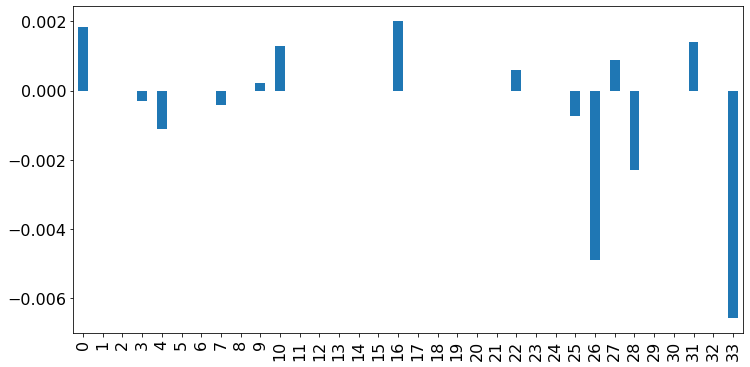

In [27]:
model_coefs.plot.bar()
plt.show()

In [28]:
mod_lasso.intercept_

0.0

In [29]:
pl_cv.best_score_

-0.07984505277442124

In [30]:
pl_cv.best_params_

{'model__alpha': 0.0001, 'model__fit_intercept': False}

TODO: implement a custom evaluation metric that measures directional accuracy and get a CV-value of this metric ;)

TODO: Improve model performance (feature engineering? feature crossing? advanced hyperparamenter tunning?)